# Calculating Multi-Modal Concordance

In [1]:
from azureml.core import Workspace
from model_drift import settings
from model_drift.azure_utils import download_metrics_file
from model_drift.drift.io import load_metrics_file, load_weights, load_stats
from model_drift.drift.unify import calculate_mmc
from model_drift.helpers import filter_columns

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (azure-mgmt-resource 13.0.0 (d:\code\mlopsday2\.venv\lib\site-packages), Requirement.parse('azure-mgmt-resource<21.0.0,>=15.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (azure-mgmt-resource 13.0.0 (d:\code\mlopsday2\.venv\lib\site-packages), Requirement.parse('azure-mgmt-resource<21.0.0,>=15.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (azure-mgmt-resource 13.0.0 (d:\code\mlopsday2\.venv\lib\site-packages), Requirement.parse('azure-mgmt-resource<21.0.0,>=15.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml

## Download results from AzureML
Skip this step if you are running locally.

In [2]:
# Get results file from azure ml
workspace = Workspace.from_config(settings.AZUREML_CONFIG)
experiment = "generate-drift-metrics"
run = "good_stamp_bdz1lskm"
results_csv = download_metrics_file(run, settings.RESULTS_DIR.joinpath('drift'), experiment, workspace, overwrite=False)

## Calculating MMC

We first load the results from the csv file, and pick which aggregate measure we wish to use. Options are: 
    - `"mean"` (default) the aggregate mean metric after N over-sampled trials
    - `"median"` the aggregate mean metric after N over-sampled trials
    - `"obs"` for observed metrics (no resampling)

From these metrics, we pick out the performance columns and filter the metrics dataframe to only include the desired individual metrics. 
In this case, we use only the `"distance"` metrics from KS test and Chi-Square tests.

Next, we load our values for shift ($\zeta_i$) and scale ($\eta_i$), as well as our metric weights ($\alpha_i$).

Finally, we calculate the MMC from these metrics using the helper function `model_drift.drift.unify.calculate_mmc`.
This function uses the weights and standardization values to calculate MMC as follows:
$$
\mathit{MMC}(\omega) = \sum_{i=1}^{L} \alpha_i \cdot \Gamma_i\bigg(\hat{\psi}_i(\omega)\bigg) = \sum_{i=1}^{L}\frac{\alpha_i}{\eta_i}\bigg(\hat{\psi}_i(\omega)-\zeta_i\bigg)
$$
For $\Gamma(\cdot)$ we used `model_drift.drift.unify.standardize`, and the weighted sum is handled by `model_drift.drift.unify.w_avg`


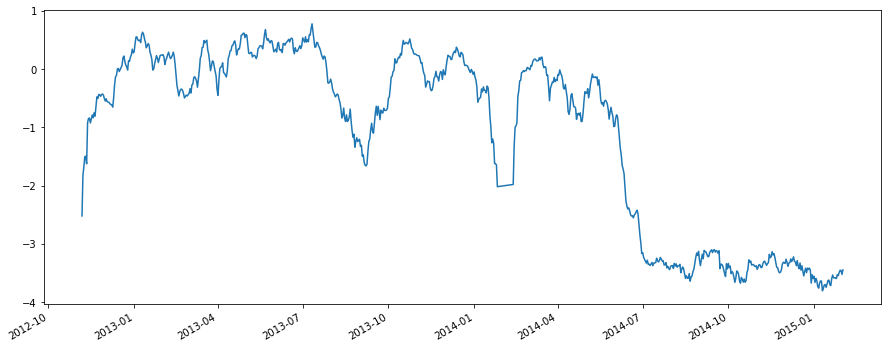

In [6]:
# Parameters
performance_col = ("performance", "micro avg", "auroc")
weights_file = settings.MODEL_DIR.joinpath("weights", "metric_weights.csv")
stats_file = settings.MODEL_DIR.joinpath("weights", "std_stats.csv")
include_metrics = ["distance"]


# Load individual metrics
error_df, results_df = load_metrics_file(results_csv, which="mean")

# Get performance from results
perf_df = results_df[performance_col]
error_perf_df = error_df[performance_col]

# Filter metrics to only desired individual metrics
metrics_df = filter_columns(results_df, exclude=['performance', 'count'])
metrics_df = filter_columns(metrics_df, include=include_metrics)

# Load weights, shifts and offsets
weights = load_weights(weights_file)
std_stats = load_stats(stats_file)

#calculate mmc
mmc = calculate_mmc(metrics_df, weights=weights, std_stats=std_stats)


mmc.plot(figsize=(15, 6))

## Interactive Plot using Plotly

In [7]:
from model_drift.figure_helper import FigureHelper
import pandas as pd

# We smooth for aesthetics when plotting
def smooth(y: pd.DataFrame, span=7):
    if span > 0:
        ys = y.ewm(span=span, ignore_na=False).mean()
        ys[y.isna()] = None
    else:
        ys = y
    return ys


span = 7
graph_start = "2014-04-01"
graph_end = "2015-02-01"

x = pd.date_range(mmc.index.min(), mmc.index.max())
fh = FigureHelper(x, color_list=['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#8C564B', '#7f7f7f'])

perf_df = perf_df.reindex(x)
error_perf_df = error_perf_df.reindex(x)
mmc = mmc.reindex(x)

fh.add_trace(y=smooth(perf_df, span=span),
             yu=smooth(perf_df+error_perf_df, span=span),
             yl=smooth(perf_df-error_perf_df, span=span), name=run, connectgaps=False, row=1, col=1, showlegend=True)

fh.add_trace(y=smooth(mmc, span=span), name=run, connectgaps=False, row=2, col=1)

fig = fh.make_fig(shared_xaxes=True, vertical_spacing=0.025)
fig.update_xaxes(showspikes=True, spikecolor="black", spikesnap="cursor", spikemode="across", spikethickness=1,
                 range=[graph_start, graph_end])
fig.update_layout(spikedistance=1000, height=500, plot_bgcolor="#E8E8EA", title="Multi-Modal Data Concordance")

xaxis = dict(
    tickformat='%Y-%m-%d',
    tickmode='linear',
    dtick="M1"
)
fig.update_layout(
    xaxis1=xaxis,
    xaxis2=xaxis,
)

fig.show()
